In [1]:
# use interpolated OCO2 average kernel, to calculate xco2 for all tagged species

In [2]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import re

In [4]:
case_name = 'CO2-2018-04'
imonth    = 4
name_month = 'Apr' # Jan, Feb, Mar
mode       = 'N' # 'N': Nadir, 'NG': Glint

In [5]:
input_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + case_name + '/nd51/'
model_file_name = 'interpolated_2d_ts_satellite.20180' + str(imonth) + '.nc'  
ds_model = xr.open_dataset(input_dir + model_file_name)

mask_dir = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
mask_name = 'flatten_mask.nc'
ds_mask = xr.open_dataset(mask_dir + mask_name)

output_directory = input_dir
if mode == 'N':
    output_file = output_directory + 'delta_y0_model_N_' + name_month + '.nc'
else:
    output_file = output_directory + 'delta_y0_model_' + name_month + '.nc'

In [6]:
varnames = list(ds_model.data_vars.keys())  # Get a list of variable names
co2_var_names = varnames[2:24] # all of the tagged species
co2_var_names

['SpeciesConc_CO2Tag1',
 'SpeciesConc_CO2Tag2',
 'SpeciesConc_CO2Tag3',
 'SpeciesConc_CO2Tag4',
 'SpeciesConc_CO2Tag5',
 'SpeciesConc_CO2Tag6',
 'SpeciesConc_CO2Tag7',
 'SpeciesConc_CO2Tag8',
 'SpeciesConc_CO2Tag9',
 'SpeciesConc_CO2Tag10',
 'SpeciesConc_CO2Tag11',
 'SpeciesConc_CO2Tag12',
 'SpeciesConc_CO2Tag13',
 'SpeciesConc_CO2Tag14',
 'SpeciesConc_CO2Tag15',
 'SpeciesConc_CO2Tag16',
 'SpeciesConc_CO2Tag17',
 'SpeciesConc_CO2Tag18',
 'SpeciesConc_CO2Tag19',
 'SpeciesConc_CO2Tag20',
 'SpeciesConc_CO2Tag21',
 'SpeciesConc_CO2Tag22']

In [7]:
satellite_file_name = '/geos/u73/msadiq/satellite/oco-2/2d_OCO2_extract_20180'+ str(imonth) + '.nc'
ds_satellite = xr.open_dataset(satellite_file_name)

avg_kern = ds_satellite['xco2_averaging_kernel']
co2_pr   = ds_satellite['co2_profile_apriori']
pres_wgt = ds_satellite['pressure_weight']
op_mode     = ds_satellite['operation_mode'] # 0=Nadir, 1=Glint
mode_mask= (op_mode-1)*-1 # mask to mask out glint, 1=Nadir, 0=Glint
#['operation_mode'][19000:20000].plot()

In [8]:
# new dataset to store all model xco2
lat = ds_model['lat']
delta_y_model = lat.to_dataset()
delta_y_model['lon'] = ds_model['lon']
delta_y_model['date'] = ds_model['date']
delta_y_model

<xarray.Dataset>
Dimensions:  (record: 393120)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 393115 393116 393117 393118 393119
Data variables:
    lat      (record) float64 ...
    lon      (record) float64 ...
    date     (record) datetime64[ns] ...

In [9]:
# loop over tag species to compute delta y0
for ivar in co2_var_names:   
    co2_model = ds_model[ivar]*1e-3 # unit: ppbv to ppm
              
    xco2_tmp = pres_wgt * (1 - avg_kern) * co2_pr + pres_wgt * avg_kern * co2_model
    xco2 = xco2_tmp.sum(dim = 'levels') # sum along vertical axis, unit: ppm
        
    xco2_land = xco2 * ds_mask['land'][0:len(xco2)]  # exclude ocean
    if mode == 'N':
        xco2_mode = xco2_land * mode_mask                # select observation mode
    else:
        xco2_mode = xco2_land 
    
    tmp_name = 'X_' + ivar
    
    delta_y_model[tmp_name] = xco2_mode.copy()
    print(tmp_name + ' done!')

X_SpeciesConc_CO2Tag1 done!
X_SpeciesConc_CO2Tag2 done!
X_SpeciesConc_CO2Tag3 done!
X_SpeciesConc_CO2Tag4 done!
X_SpeciesConc_CO2Tag5 done!
X_SpeciesConc_CO2Tag6 done!
X_SpeciesConc_CO2Tag7 done!
X_SpeciesConc_CO2Tag8 done!
X_SpeciesConc_CO2Tag9 done!
X_SpeciesConc_CO2Tag10 done!
X_SpeciesConc_CO2Tag11 done!
X_SpeciesConc_CO2Tag12 done!
X_SpeciesConc_CO2Tag13 done!
X_SpeciesConc_CO2Tag14 done!
X_SpeciesConc_CO2Tag15 done!
X_SpeciesConc_CO2Tag16 done!
X_SpeciesConc_CO2Tag17 done!
X_SpeciesConc_CO2Tag18 done!
X_SpeciesConc_CO2Tag19 done!
X_SpeciesConc_CO2Tag20 done!
X_SpeciesConc_CO2Tag21 done!
X_SpeciesConc_CO2Tag22 done!


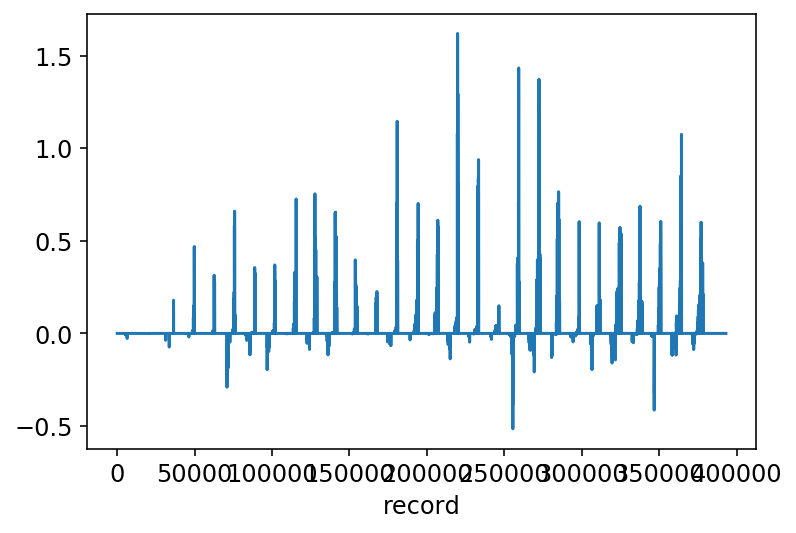

In [10]:
diff = delta_y_model['X_SpeciesConc_CO2Tag11'] - delta_y_model['X_SpeciesConc_CO2Tag2']
diff.plot()

In [11]:
delta_y_model

<xarray.Dataset>
Dimensions:                 (record: 393120)
Coordinates:
  * record                  (record) int64 0 1 2 3 ... 393117 393118 393119
Data variables:
    lat                     (record) float64 ...
    lon                     (record) float64 ...
    date                    (record) datetime64[ns] ...
    X_SpeciesConc_CO2Tag1   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag2   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag3   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag4   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag5   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag6   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag7   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag8   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag9   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag10  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag11  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag12  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag13  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag14  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag15  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag16  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag17  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag18  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag19  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag20  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag21  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_SpeciesConc_CO2Tag22  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [12]:
delta_y_model.to_netcdf(output_file)